In [1]:
import numpy as np
from matplotlib import pyplot as plt

import dftpy
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.time_data import TimeData
from dftpy.optimization import Optimization
from dftpy.mpi import sprint

from qepy.calculator import QEpyCalculator 
from qepy.io import QEInput
from qepy.driver import Driver 

from ase.build import bulk
from ase.io.trajectory import Trajectory
from ase.io import read
from ase.units import kJ
from ase.eos import EquationOfState
from ase import Atoms
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal
from ase.visualize import view

/home/valeria/anaconda3/lib/python3.9/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


In [2]:
from scipy.optimize import minimize
try:
    from mpi4py import MPI
    comm=MPI.COMM_WORLD
except:
    comm=None
path_pp='/home/valeria/Desktop/programs/dftpy/examples/ofpp/EAC/upf/blps/'
file1='si.lda.upf'
PP_list = {'Si': path_pp+file1}

In [3]:
qe_options = {
        '&control': {
            'calculation': "'scf'",
            'prefix': "'si'",
            'pseudo_dir': "'/home/valeria/Desktop/programs/dftpy/examples/ofpp/EAC/upf/blps/'",
            'restart_mode': "'from_scratch'"},
        '&system': {
            'ibrav' : 1,
            'nat': 4,
            'degauss': 0.005,
            'ecutwfc': 60,
            'occupations': "'smearing'"},
        'atomic_species': ['Si  28.08 si.lda.upf'],
        'cell_parameters angstrom': ['3.405    0.0000000000000000    0.0000000000000003',
                                     '0.0000000000000009    3.405   0.0000000000000003',
                                     '0.0000000000000000    0.0000000000000000    3.405'],
         'k_points automatic': ['20 20 20 1 1 1']}

# KS DFT
l = np.linspace(0.8, 1.4, 30)
# RHO = []
ks_ke = []
for i in np.arange(0, len(l), 1):
        n = int(i)
        X = l[n]
        si = bulk('Si', 'fcc', a= 3.405, cubic=True)
        cell = si.get_cell()
        si.set_cell(cell * X, scale_atoms=True)
        qe_options = QEInput.update_atoms(si, qe_options = qe_options,  extrapolation=False)
        QEInput().write_qe_input("/home/valeria/Documents/DFTPY/Fitting_densities/Si-fcc/DATA2/Si"+str(n)+".in", qe_options=qe_options)
        driver = Driver('/home/valeria/Documents/DFTPY/Fitting_densities/Si-fcc/DATA2/Si'+str(n)+'.in', comm=comm, logfile='/home/valeria/Documents/DFTPY/Fitting_densities/Si-fcc/DATA2/Si'+str(n)+'.out')
        driver.scf()
        driver.calc_energy()
        D = driver.get_output()
        k = [match for match in D if "Kinetic energy" in match]
        KS_KE = str(k).split()[6]
        v_men = driver.get_effective_potential().mean()
        KS_PE = driver.data2field(driver.get_effective_potential() - v_men)
        rho = driver.data2field(driver.get_density())
        ions = driver.get_dftpy_ions()
        rho.write('/home/valeria/Documents/DFTPY/Fitting_densities/Si-fcc/DATA2/rho0'+str(i)+'.xsf', ions=ions)
        driver.stop()
#         RHO.append(rho)
        ks_ke.append(KS_KE)

In [4]:
np.save("/home/valeria/Documents/DFTPY/Fitting_densities/Si-fcc/DATA2/ks_ke.npy",np.asarray(ks_ke))

In [4]:
KS_KE = []
for i in np.arange(0,len(l),1):
    ke = float(ks_ke[int(i)])
    KS_KE.append(ke)

In [5]:
import pickle
var = np.asarray(KS_KE)
with open('ks_ke.pkl', 'wb') as f:
    pickle.dump(var,f)

In [7]:
with open('ks_ke.pkl','rb') as f:
    ks_ke = pickle.load(f)

In [8]:
class setting:
    def sett(ions, rho, scaling):
        ions = ions
        rho = rho
        scaling = scaling
        cell = ions.get_cell()
        ions.set_cell(cell * scaling, scale_atoms=True) 
        nr = ecut2nr(ecut=147, lattice=ions.cell)
        grid = DirectGrid(lattice=ions.cell, nr=[len(rho),len(rho),len(rho)])
        PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list)  
        XC = Functional(type='XC',name='LDA')
        HARTREE = Functional(type='HARTREE')
        return PSEUDO, HARTREE, XC

In [9]:
def min_energy(x0, *args):
        KS_KE, KS_PE, rho = args
        KE = Functional(type='KEDF',name='WT', rho0=x0) 
        OF_KE = KE(rho).energy
#         pot = KE(rho, calctype = {'V'}).potential
#         OF_PE =  pot - pot.min()
#         pot = rho*(KS_PE - OF_PE)
        diff = 0.1*(float(OF_KE)-float(KS_KE)*(1/2))**2 #+ 0.1*(pot.integral())**2
#         print(x0)
        return diff

In [10]:
ions = Ions.from_ase(bulk('Si', 'fcc', a= 3.405, cubic=True))
# i = 2
l = np.linspace(0.9, 1.5, 10)
delta_E = []
Rho0 = []
for n in np.arange(0,len(l),1):
    i = int(n)
    rho = io.read_density('rho0'+str(i)+'.xsf')
#     rho = RHO[int(i)]
    scaling = l[i]

    PSEUDO, HARTREE, XC = setting.sett(ions,rho,scaling)
    H_PE = HARTREE(rho, calctype = {'V'}).potential
    XC_PE = XC(rho, calctype = {'V'}).potential
    PP_PE = PSEUDO(rho, calctype = {'V'}).potential
    
    KS_KE = ks_ke[int(i)]
    Ef_PE = H_PE + XC_PE + PP_PE
    KS_PE = Ef_PE - Ef_PE.min()
    
    bnds = ((0, None))
    minn = minimize(min_energy, 0.02, args = (KS_KE, KS_PE, rho), method='Nelder-Mead',
               options={'xtol': 1e-4,'disp': True})
    delta_E.append(minn.fun)
    Rho0.append(minn.x)
    print(minn.x)

setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/DATA/ofpp/si.lda.upf


/tmp/ipykernel_638744/739585304.py:22: OptimizeWarning: Unknown solver options: xtol
  minn = minimize(min_energy, 0.02, args = (KS_KE, KS_PE, rho), method='Nelder-Mead',
/home/valeria/anaconda3/lib/python3.9/site-packages/dftpy/functional/kedf/kernel.py:329: RuntimeWarning: invalid value encountered in power
  tkf = 2.0 * (3.0 * rho0 * np.pi ** 2) ** (1.0 / 3.0)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 22
[0.0048125]
setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/DATA/ofpp/si.lda.upf
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 18
[0.0145]
setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/DATA/ofpp/si.lda.upf
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 16
[0.017]
setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/DATA/ofpp/si.lda.upf
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 12
         Function evaluations: 24
[0.042625]
setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/DATA/ofpp/si.lda.upf
Optimization terminated successfully.
         Current function va

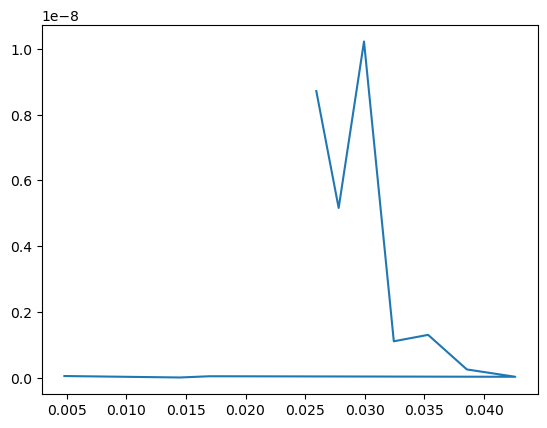

In [11]:
plt.plot(Rho0,delta_E)